In [2]:
import numpy as np
import neptune
import imageio
import scipy as scipy
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.data_loader import _shift_image
from src.test_models.drduplex import DRDuplex

Using TensorFlow backend.


In [3]:
exp_date = '2019-09-26'
proj_root = '/home/elijahc/projects/vae'
models_root = os.path.join(proj_root,'models',exp_date)

In [4]:
PROPS = {
    'dataset':'fashion_mnist',
    'encoder_arch': 'dense',
    'generator_arch': 'resnet',
    'augmentation': 'single',
}
PARAMS = {}

train_conf = {
    'n_epochs': 54000,
    'batch_sz':512,
}

data_conf = {
    'bg': 'natural',
    'im_translation':0.75,
    'im_rotation':None,
    'bg_contrast': 0.3,
}

model_conf = {
    'xent_weight': 15,
    'recon_weight': 0,
}

for conf in [train_conf,data_conf,model_conf]:
    PARAMS.update(conf)

In [5]:
PARAMS

{'n_epochs': 54000,
 'batch_sz': 512,
 'bg': 'natural',
 'im_translation': 0.75,
 'im_rotation': None,
 'bg_contrast': 0.3,
 'xent_weight': 15,
 'recon_weight': 0}

In [6]:
oversample_factor=1
DL = Shifted_Data_Loader(dataset=PROPS['dataset'],flatten=False,num_train=60000*oversample_factor,
                         translation=PARAMS['im_translation'],
                         rotation=PARAMS['im_rotation'],
#                          contrast_level=PARAMS['bg_contrast'],
                         bg=PARAMS['bg'],
                         blend=None,
                        )

input_shape:  (56, 56, 1)
dataset:  fashion_mnist
background:  natural
blend mode:  None
scale:  2
tx_max:  0.75
rot_max:  None
contrast_level:  1
noise_mode:  None
building background images...


test_images: 100%|██████████| 10000/10000 [00:00<00:00, 35013.57it/s]


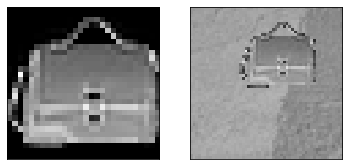

In [7]:
pt,idx = plot_ovt(DL,cmap='gray')

In [8]:
neptune.init('elijahc/DuplexAE')
src_files = ['./src/data_loader.py','./src/test_models/drduplex.py']
exp = neptune.create_experiment(name='static_aug_w_recon',properties=PROPS,params=PARAMS,upload_source_files=src_files)
exp_dir = os.path.join('models',exp_date,exp.id) 

os.mkdir(os.path.join(proj_root,exp_dir))
os.mkdir(os.path.join(proj_root,exp_dir,'recons'))
os.mkdir(os.path.join(proj_root,exp_dir,'test_ims'))

exp.set_property('dir',exp_dir)

MissingApiToken: Missing API token. Use "NEPTUNE_API_TOKEN" environment variable or pass it as an argument

In [11]:
w_xent = PARAMS['xent_weight']
w_recon = PARAMS['recon_weight']

In [12]:
mod = DRDuplex(img_shape=(56,56,1),
               num_classes=DB.num_classes,
               recon=w_recon,
               xent=w_xent,n_residual_blocks=4,
#                kernel_regularization=1e-5,
              )

In [13]:
mod.combined.metrics_names

['loss',
 'Generator_loss',
 'Classifier_loss',
 'Generator_mean_squared_error',
 'Classifier_acc']

In [14]:
# val_pct = 0.05
# val_idxs = np.random.choice(np.arange(10000),int(val_pct*60000),replace=False)
# validation_set = (DB.x_te[val_idxs],
#                   {'Classifier':DB.y_test_oh[val_idxs],
#                    'Generator':DB.fg_test[val_idxs]}
#                  )

In [15]:
i = 0
epoch_sz = int(DB.num_train/512)
pan_ims = []
pan_y = []

# hist_labels = mod.combined.metrics_names
hist_labels = ['loss','G_loss','C_loss','G_mse','acc']

train_hist = []
test_hist = []

# val_X,val_X_fg,val_y = DB.gen_batch(DB.x_te,DB.y_test_oh,batch_size=1000,bg='natural')


In [18]:
num_pan = 3
test_generator = DB.gen_test_batches(4, batch_size=PARAMS['batch_sz'], bg=PARAMS['bg'])
not_unique = True
while not_unique:
    pan_idx = np.random.choice(np.arange(len(DB.x_te)),size=num_pan,replace=False)
    if len(np.unique(DB.y_test[pan_idx])) == num_pan:
        not_unique = False
    
px_ = DB.x_te[pan_idx]
print(px_.shape)
tX, tX_fg,ty = next(test_generator)

(3, 28, 28)


In [19]:
x_span = DB.gen_pan_deltas(step=2)
pX = np.stack([np.expand_dims(_shift_image(X=px_,dx=dx,dy=dy),-1) for dx,dy in x_span])

scaler = MinMaxScaler(feature_range=(-1,1))
n,r,x,y,c = pX.shape

pX = scaler.fit_transform(pX.reshape(n,x*y*c*r)).reshape(n,r,x,y,c)

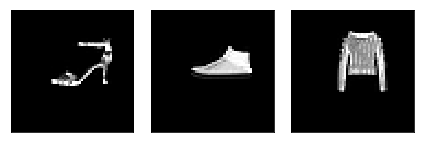

In [20]:
fig,axs = plt.subplots(1,num_pan)
for i,ax in enumerate(axs.ravel()):
    ax.imshow(pX[27,i].reshape(56,56),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.tight_layout()

In [21]:
# import numpy as np
# nj = 25
# fig,axs = plt.subplots(1,nj,figsize=(2*nj,2))

# for i in np.arange(nj):
#     axs[i].imshow(pX[i+15].reshape(56,56))

In [22]:
def flush_pan(pan_ims):
    min_max = lambda xp: np.clip((xp+1)/2,0,1)
    for idx,inp,G in pan_ims:
        idx = str(idx).zfill(3)
        
#         inp_fn = 'input_{}.png'.format(idx)
#         inp_fp = os.path.join(proj_root,exp_dir,'test_ims',inp_fn)
        
        G_fn = 'G_{}.png'.format(idx)
        G_fp = os.path.join(proj_root,exp_dir,'recons',G_fn)
    
        fig,axs = plt.subplots(2,num_pan)
        for k in np.arange(num_pan):
            axs[0,k].imshow(inp[k],cmap='gray')
            axs[1,k].imshow(G[k],cmap='gray')

        for ax in axs.ravel():
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.tight_layout()     
        
        fig.savefig(G_fp)
        plt.close(fig)

In [23]:
recon_dir = os.path.join(proj_root,exp_dir,'recons')
input_dir = os.path.join(proj_root,exp_dir,'test_ims')

In [24]:
def make_gif(recon_dir,input_dir,fps=8,loop=0):
    G_ims = []
    for G in sorted(os.listdir(recon_dir)):
        if G.endswith('.png'):
            G_fp = os.path.join(recon_dir, G)
            G_ims.append(imageio.imread(G_fp))
        
#     imageio.mimsave(os.path.join(proj_root,exp_dir,'inputs_video.gif'), input_ims,fps=fps,loop=loop)
    imageio.mimsave(os.path.join(proj_root,exp_dir,'G_video.gif'), G_ims, fps=fps,loop=loop)

In [ ]:
for X,X_fg,y in DB.gen_train_batches(PARAMS['n_epochs'],bg=PARAMS['bg']):
    y = {'Classifier':y,
         'Generator':X_fg,
        }
    r = mod.combined.train_on_batch(X,y)
    r = {k:v for k,v in zip(hist_labels,r)}

#     metrics = {k:v for k,v in zip(met_names,met_vals)}
    if i % epoch_sz == 0 and i > 0:
        r_te = mod.combined.test_on_batch(tX,{'Classifier':ty,
                                              'Generator':tX_fg
                                             })
        r_te = {k:v for k,v in zip(hist_labels,r_te)}
        exp.log_metric('batch',i)
        for metric in hist_labels:
            exp.log_metric(metric,r[metric])
            exp.log_metric('val_{}'.format(metric),r_te[metric])

        r['batch']=i
        r_te['batch']=i

#         r['result_type'] = 'train'
#         r_te['result_type'] = 'valid'

#         train_hist.append(r)
#         train_hist.append(r_te)

        p_loss = "{:5d} (train/val) G/C_loss[{:2.2f}/{:.2f},   {:2.2f}/{:.2f}]".format(i,r['G_loss'],r['C_loss'],r_te['G_loss'],r_te['C_loss'])
#         p_loss = "{:5d} (train/val loss:[{:2.2f}, {:2.2f}])".format(i,r['loss'],r_te['loss'])
        p_acc = "[acc: {:2.2%},   val_acc: {:2.2%}]".format(r['acc'],r_te['acc'])
        print(p_loss,' ',p_acc)
        
        pidx = int(i/epoch_sz)%len(pX)
        im = pX[pidx]
        p_recon,p_class = mod.combined.predict_on_batch(im)
        
        pan_im = (int(i/epoch_sz), np.squeeze(im), np.squeeze(p_recon))
        pan_ims.append(pan_im)
        pan_y.append(p_class)
        
        if i>0 and len(pan_ims)>int(len(pX)/3):
            print('writing_image_buffer...')
            flush_pan(pan_ims)
            pan_ims = []
                
            print('recompiling video...')
            make_gif(recon_dir,input_dir)
                        
    i+=1

  117 (train/val) G/C_loss[1521.85/2.04,   1531.38/1.98]   [acc: 27.15%,   val_acc: 31.84%]
  234 (train/val) G/C_loss[1477.55/1.86,   1486.81/1.80]   [acc: 32.03%,   val_acc: 37.30%]
  351 (train/val) G/C_loss[1453.20/1.78,   1455.41/1.72]   [acc: 36.13%,   val_acc: 40.04%]
  468 (train/val) G/C_loss[1444.39/1.68,   1477.31/1.69]   [acc: 41.21%,   val_acc: 40.43%]
  585 (train/val) G/C_loss[1455.95/1.63,   1454.14/1.66]   [acc: 41.21%,   val_acc: 41.21%]
  702 (train/val) G/C_loss[1450.31/1.60,   1471.38/1.62]   [acc: 43.75%,   val_acc: 44.34%]
  819 (train/val) G/C_loss[1467.01/1.61,   1506.89/1.59]   [acc: 43.36%,   val_acc: 42.97%]
  936 (train/val) G/C_loss[1474.94/1.63,   1506.90/1.55]   [acc: 42.77%,   val_acc: 45.90%]
 1053 (train/val) G/C_loss[1451.22/1.58,   1490.69/1.52]   [acc: 41.60%,   val_acc: 45.70%]
 1170 (train/val) G/C_loss[1458.79/1.52,   1520.52/1.49]   [acc: 46.48%,   val_acc: 47.66%]
 1287 (train/val) G/C_loss[1518.06/1.57,   1545.64/1.47]   [acc: 45.51%,   val_a

In [ ]:
make_gif(recon_dir,input_dir,)

In [ ]:
exp.stop()

In [ ]:
mod_dir = os.path.join(proj_root,exp_dir)
mod_dir

In [ ]:
hist_tr = pd.DataFrame.from_records(train_hist)

In [ ]:
# sns.set_context('talk')
# fig,axs = plt.subplots(1,4,figsize=(4*4,1*4),sharex=True)
# for ax,metric in zip(axs.ravel(),['loss','G_loss','C_loss','acc']):
#     sns.lineplot(x='batch',y=metric, hue='result_type',data=hist_tr,ax=ax)

In [ ]:
print(mod_dir)
hist_tr.to_csv(os.path.join(mod_dir,'training_hist.csv'))

In [ ]:
model_json = mod.combined.to_json()
with open(os.path.join(mod_dir,"model.json"), "w") as json_file:
    json_file.write(model_json)
    
exp.send_artifact(os.path.join(mod_dir,'model.json'))

In [ ]:
mod.combined.save_weights(os.path.join(mod_dir,'weights.h5'))

In [ ]:
teX,_,_ = next(test_generator)

In [ ]:
out = mod.combined.predict_on_batch(teX)

In [ ]:
x_recon,y = out

In [ ]:
choices = np.random.choice(np.arange(1024),size=5,replace=False)

In [ ]:
fix,axes = plt.subplots(2,5,figsize=(2*5,2*2))

for i,idx in enumerate(choices):
    axs = axes[:,i]
    axs[0].imshow(teX[idx].reshape(56,56),cmap='gray')
    axs[1].imshow(x_recon[idx].reshape(56,56),cmap='gray')
    
for ax in axes.ravel():
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
plt.tight_layout()

In [ ]:
fix.savefig(os.path.join(mod_dir,'inp_output_pairs.png'),dpi=300)

In [ ]:
exp.send_artifact(os.path.join(mod_dir,'inp_output_pairs.png'))

In [ ]:
x_tr = DL.sx_train
x_tro = DL.x_train

In [ ]:
x_tro.shape

In [ ]:
im = np.squeeze(x_tr[5])
plt.imshow(x_tro[5])

In [ ]:
x_t_warp = np.zeros((28,28))
xt_warp = scipy.ndimage.zoom(x_tro[5],(1.1,0.9))
plt.imshow(xt_warp)

In [ ]:
DL.meta_train